# Forest: tree crown delineation

## Context
### Purpose
Accurately delineating trees using a state of the art deep learning model.

### Modelling approach
An established deep learning model, **Mask R-CNN** is deployed to delineate tree crowns accurately. A pre-trained model is provided to predict the location and extent of tree crowns from a top-down RGB image, captured by drone, aircraft or satellite.

### Highlights
* Detectree advances the state-of-the-art in tree identification from RGB images by delineating exactly the extent of the tree crown.
* Our pre-trained model was developed using aircraft images of tropical forests in Malaysia.
* The model can be further trained using the user's own images.

### Authors
Sebastian Hickman, University of Cambridge, @shmh40
James Ball, University of Cambridge, @PatBall1
Toby Jackson, University of Cambridge


*The authors acknowledge the authors of the Detectron2 package which provides the Mask R-CNN architecture.*


## Install and load libraries

In [1]:
### install dependencies:

# may need to install opencv
# !pip install opencv-python

# install cython and associated packages
!pip3 -q install Cython cupy-cuda112 cupy-cuda102   # Probably only need one of these but it works so I'm gonna leave it for now.
!pip3 -q install pyyaml==5.1


# install an older version of pytorch that is compatible with detectron2

!pip -q install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!python -m pip -q install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/inclu

In [2]:
## install geospatial libraries

!pip -q install geopandas
!pip -q install rasterio
!pip -q install fiona
!pip -q install shapely

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/inclu

In [3]:
# Import torch and check versions and cuda availability, and resources
# GPU access is required to train the model

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

!gcc --version
!nvcc --version
!nvidia-smi

from IPython.display import display, clear_output

1.7.1+cu110 True
gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Mar_21_19:15:46_PDT_2021
Cuda compilation tools, release 11.3, V11.3.58
Build cuda_11.3.r11.3/compiler.29745058_0
Sat Sep 11 17:58:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.181.07   Driver Version: 418.181.07   CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SX

In [13]:
# tensorboard?
#%load_ext tensorboard
#%tensorboard --logdir output

# necessary libraries
import pandas as pd
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import json
import glob

# geospatial libraries
import geopandas as gpd
from geopandas.tools import sjoin

import rasterio
from rasterio.transform import from_origin
from rasterio.plot import show
from rasterio.mask import mask
import rasterio.features

import fiona
from fiona.crs import from_epsg

from shapely.geometry import shape, mapping, box
from shapely.geometry.multipolygon import MultiPolygon

#import pycrs
#import descartes


# import some common detectron2 utilities

import detectron2
#from detectron2.utils.logger import setup_logger
#setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

# Make sure the inevitable error messages are useful.
CUDA_LAUNCH_BLOCKING="1"

## Load data

#### Load in a tiff of aerial forest imagery using *intake*

In [5]:
# first install intake library
!pip -q install intake
!pip -q install git+https://github.com/ESM-VFC/intake_zenodo_fetcher.git 
!pip -q install intake-xarray

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None


In [6]:
# import libraries for intake
import intake
from intake_zenodo_fetcher import download_zenodo_files_for_entry
import tempfile

In [7]:
# create a temp dir
path = tempfile.mkdtemp()

catalog_file = os.path.join(path, 'catalog.yaml')

with open(catalog_file, 'w') as f:
    f.write('''
sources:
  sepilok_rgb:
    driver: rasterio
    description: 'NERC RGB images of Sepilok, Sabah, Malaysia (collection)'
    metadata:
      zenodo_doi: "10.5281/zenodo.5494629"
    args:
      urlpath: "{{ CATALOG_DIR }}/Sep_2014_RGB_602500_646600.tif"
      ''')

In [8]:
cat_tc = intake.open_catalog(catalog_file)

In [9]:
for catalog_entry in list(cat_tc):
    download_zenodo_files_for_entry(
        cat_tc[catalog_entry],
        force_download=False
    )

will download https://zenodo.org/api/files/271e78b4-b605-4731-a127-bd097e639bf8/Sep_2014_RGB_602500_646600.tif to /tmp/tmptbj_2ejy/Sep_2014_RGB_602500_646600.tif


  0%|          | 0.00/100 [00:00<?, ?B/s]

In [10]:
tc_rgb = cat_tc["sepilok_rgb"].to_dask()

#### Inspect the aerial raster of the location

In [11]:
# let's investigate the data-array, what is the shape? Bounds? Bands? CRS?

print('shape =', tc_rgb.shape,',', 'and number of bands =', tc_rgb.count, ', crs =', tc_rgb.crs)

shape = (4, 1400, 1400) , and number of bands = <bound method ImplementsArrayReduce._reduce_method.<locals>.wrapped_func of <xarray.DataArray (band: 4, y: 1400, x: 1400)>
array([[[36166.285 , 34107.22  , ..., 20260.998 , 11166.631 ],
        [32514.84  , 28165.994 , ..., 24376.36  , 21131.947 ],
        ...,
        [15429.493 , 16034.794 , ..., 19893.691 , 19647.646 ],
        [12534.722 , 14003.215 , ..., 21438.908 , 22092.525 ]],

       [[38177.168 , 36530.74  , ..., 19060.268 , 11169.006 ],
        [34625.227 , 30270.379 , ..., 21760.09  , 20796.621 ],
        ...,
        [17757.678 , 16818.102 , ..., 22538.023 , 23093.508 ],
        [13403.302 , 13354.489 , ..., 24638.21  , 25545.938 ]],

       [[13849.501 , 14158.603 , ...,  9385.764 ,  7401.662 ],
        [13252.31  , 13373.801 , ..., 12217.845 , 10666.252 ],
        ...,
        [13471.741 , 11533.697 , ...,  7536.6924,  8397.009 ],
        [13724.59  , 11057.722 , ...,  9778.8125, 11174.72  ]],

       [[65535.    , 65535. 

#### Save the RGB bands our our tiff as a png (needed for Mask R-CNN to predict on)

In [ ]:
minx = 602500
miny = 646600

R = tc_rgb[0]
G = tc_rgb[1]
B = tc_rgb[2]
    
# stack up the bands in an order appropriate for saving with cv2, then rescale to the correct 0-255 range for cv2

# you will have to change the rescaling depending on the values of your tiff!
rgb = np.dstack((R,G,B)) # BGR for cv2
rgb_rescaled = 255*rgb/65535 # scale to image
    
# save this as png, named with the origin of the specific tile - change the filepath!
cv2.imwrite('/home/jovyan/lustre_scratch/sepilok_data/spare_pngs/tile_'+str(minx)+'_'+str(miny)+'.png', rgb_rescaled)

#### Now read in and display this png

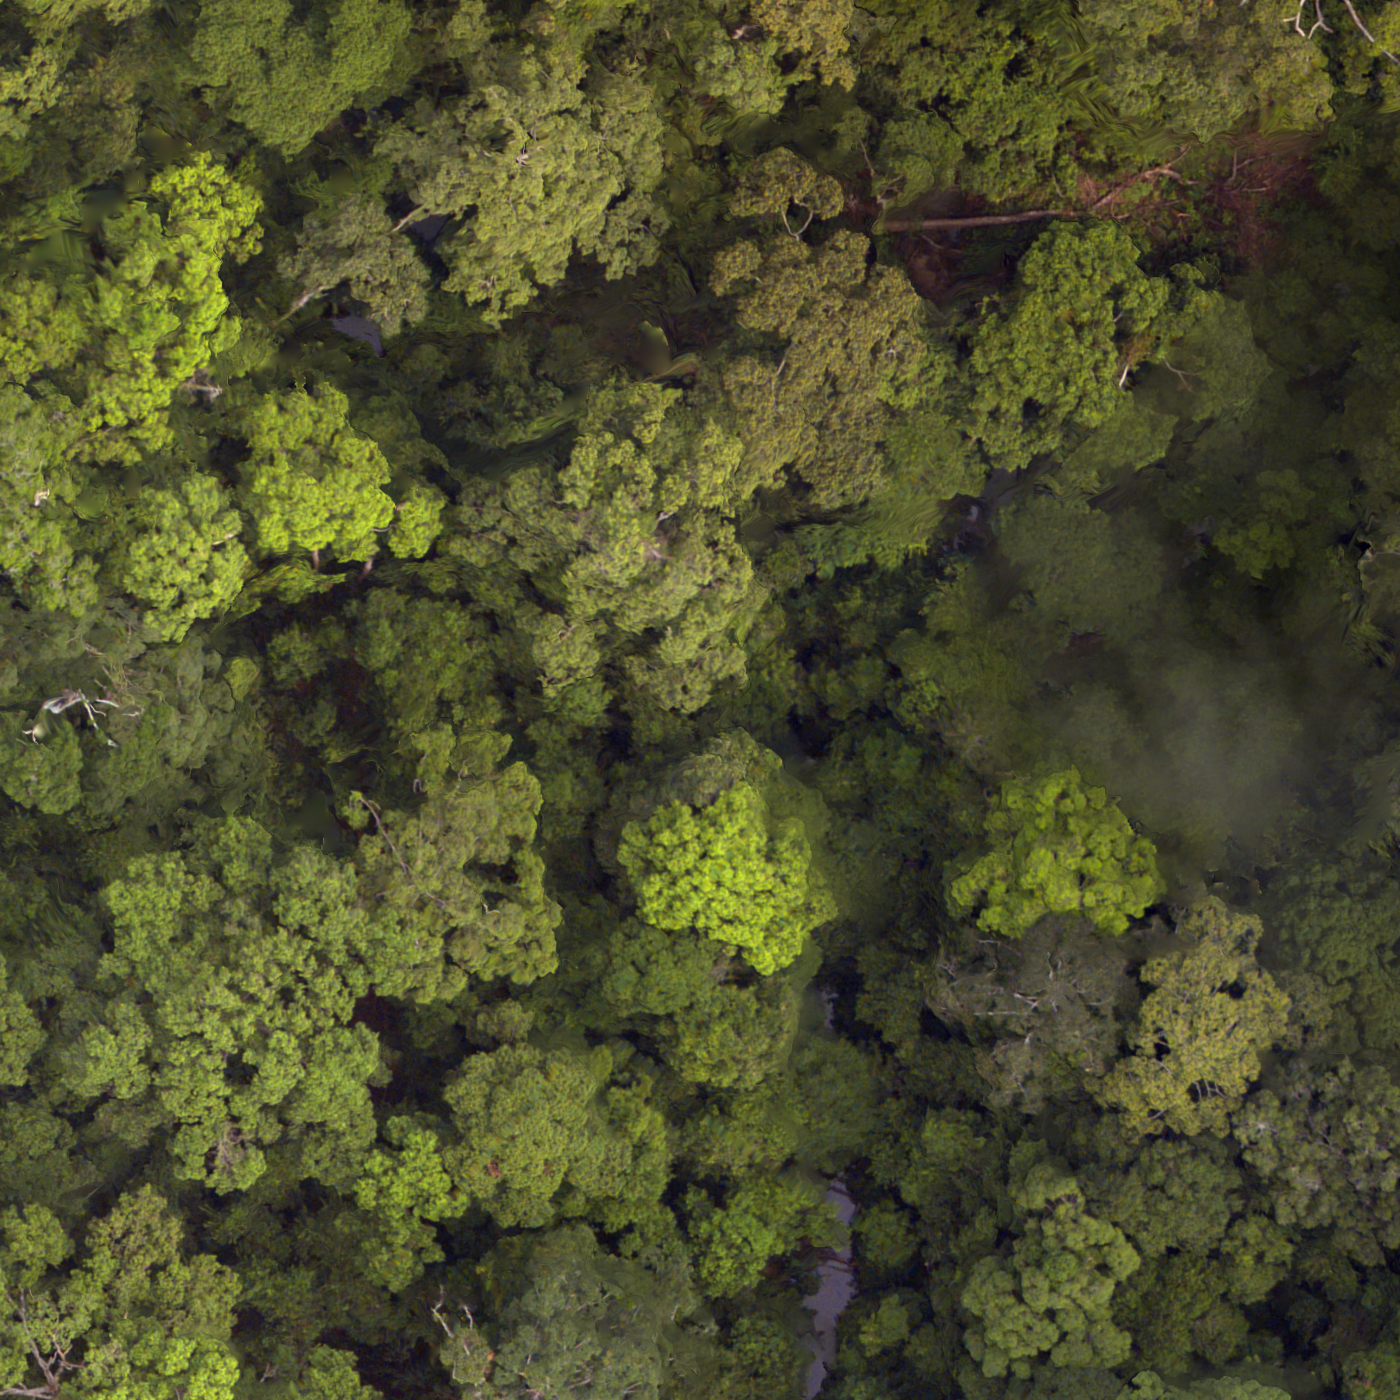

In [14]:
filepath = "/home/jovyan/lustre_scratch/sepilok_data/spare_pngs/tile_602500_646600.png"
im = cv2.imread(filepath)
display(Image.fromarray(im))

## Modelling

#### Make predictions on our png

In [15]:
from detectron2.utils.visualizer import ColorMode
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

### path to the saved pre-trained model weights
cfg.MODEL.WEIGHTS = '/home/jovyan/detectron2_live/train_test/output/model_final.pth'

# set confidence threshold at which we predict
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.15

predictor = DefaultPredictor(cfg)

## Outputs

#### First generate an image showing the predictions from detectree

/opt/conda/lib/python3.8/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


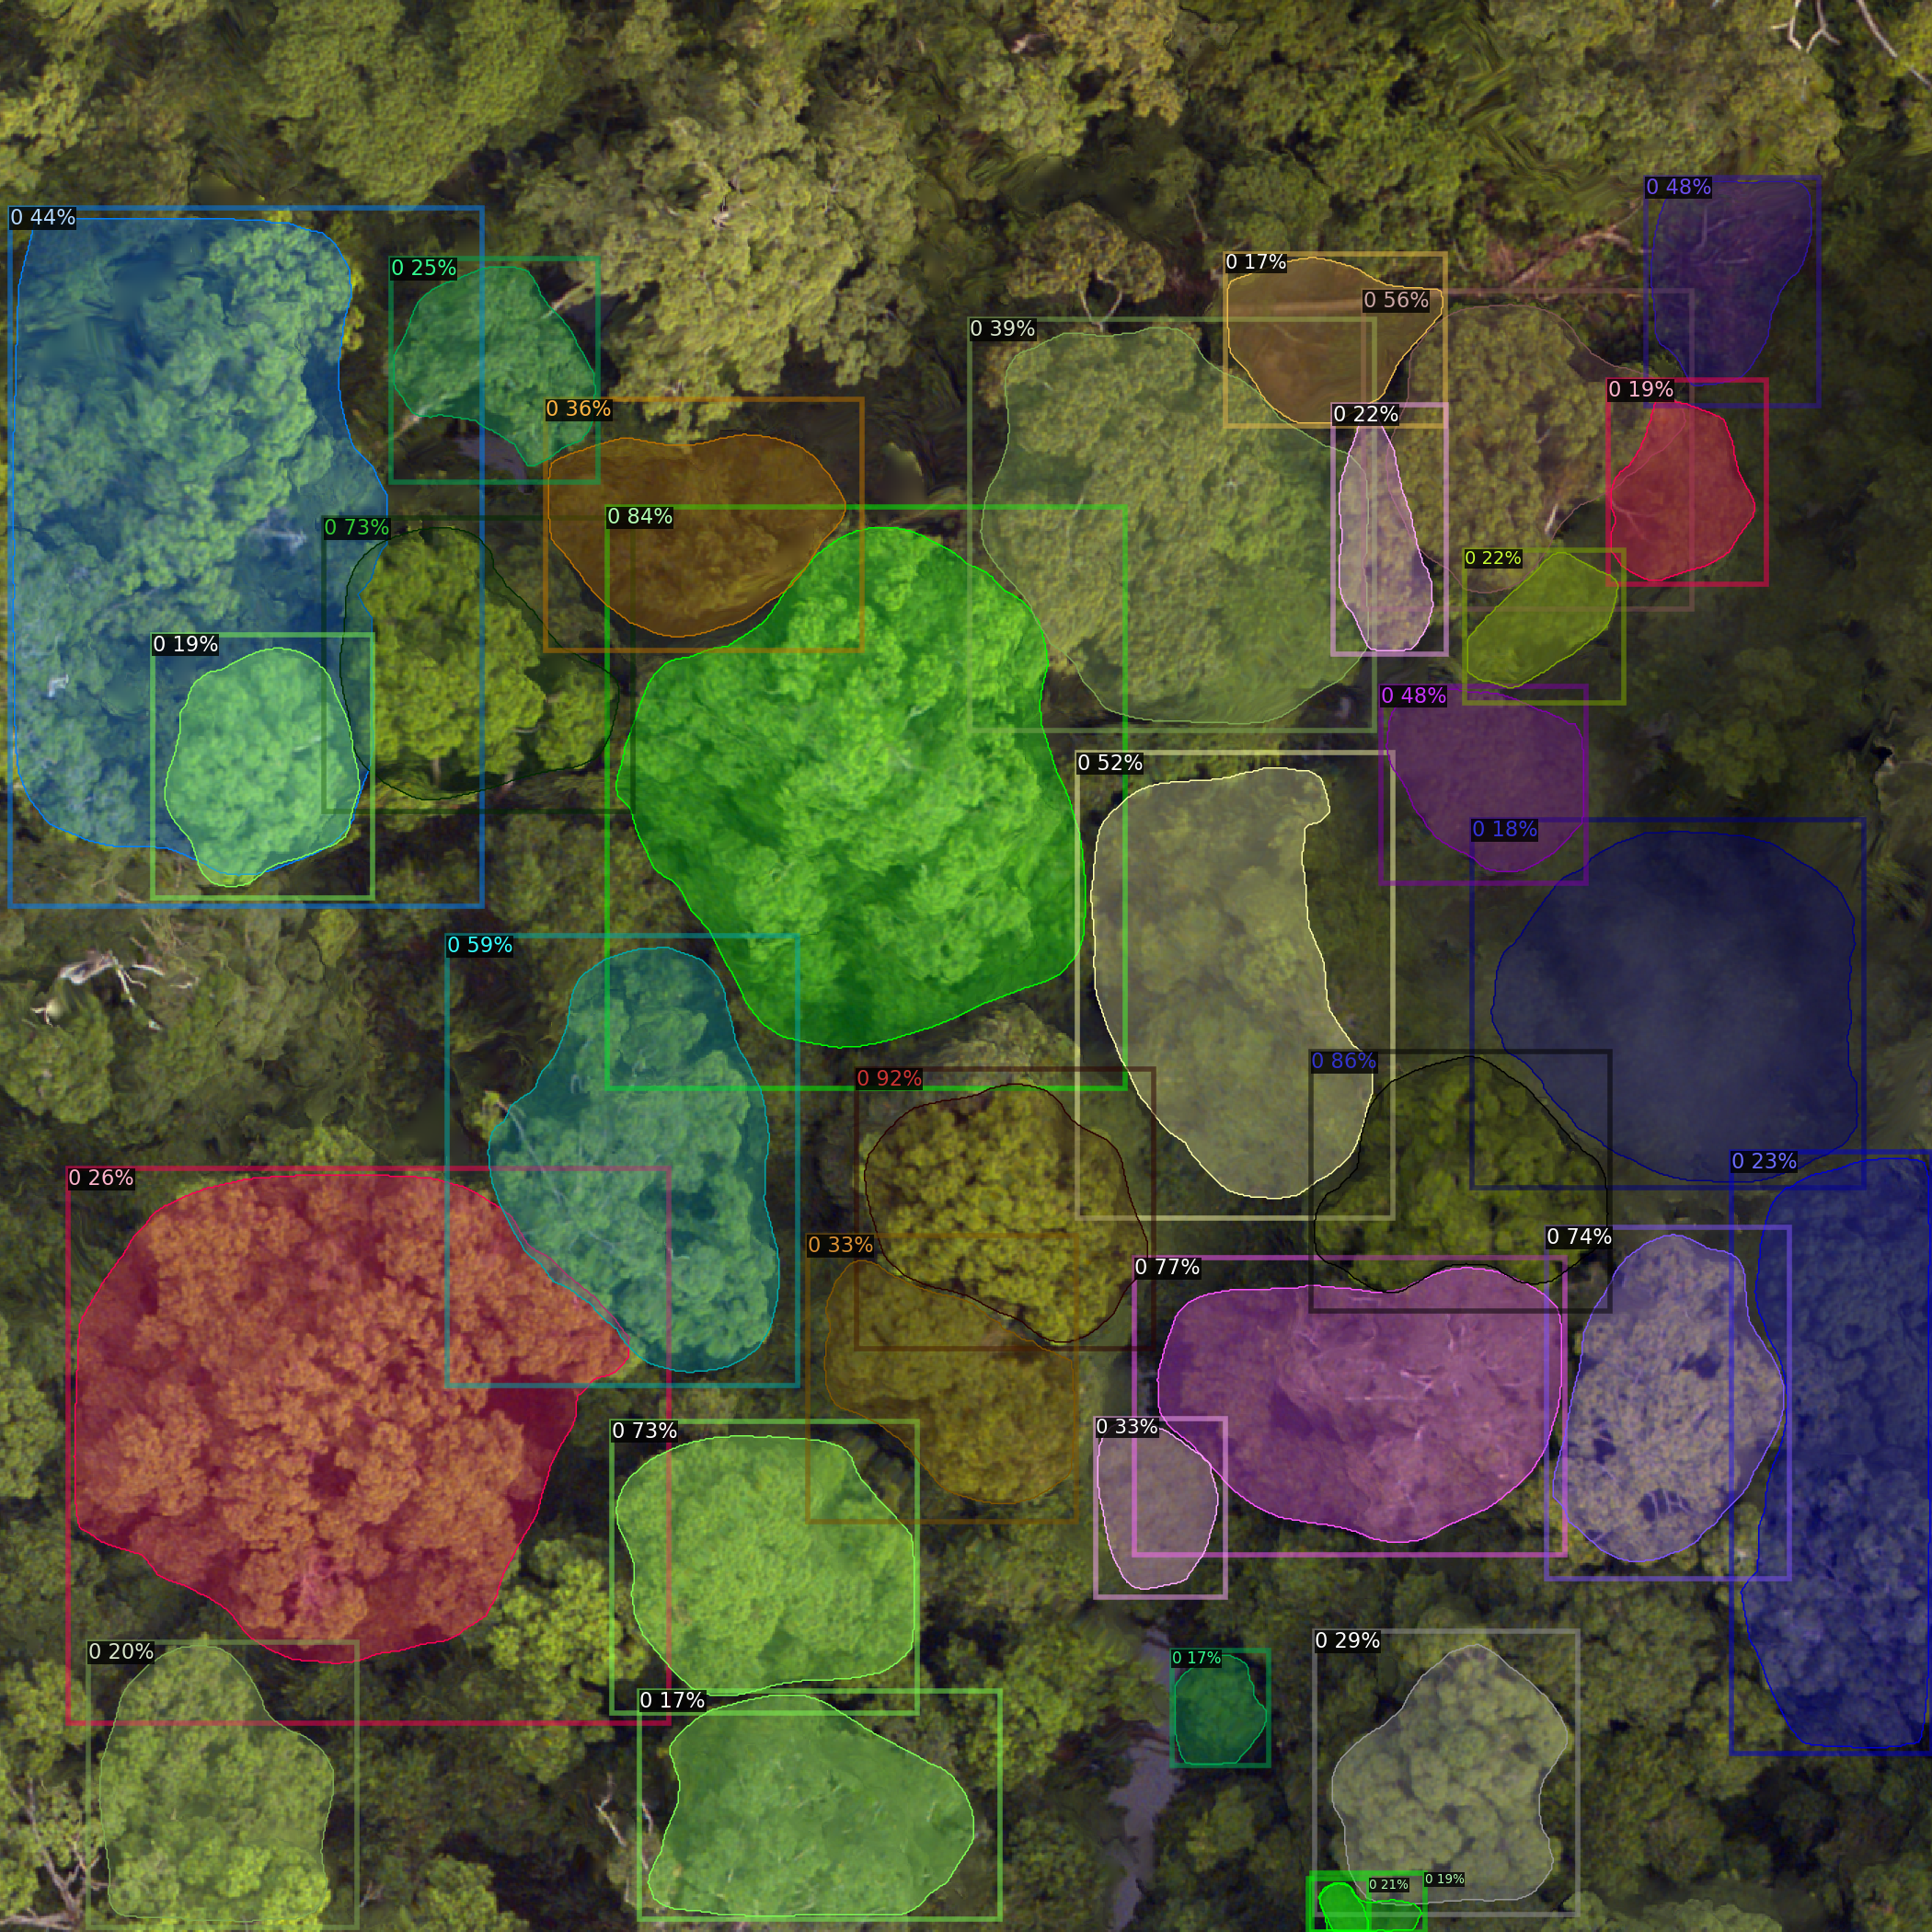

In [16]:
# output an image of predicted crowns

outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], scale=1.5, instance_mode=ColorMode.IMAGE_BW)   # remove the colors of unsegmented pixels
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
image = cv2.cvtColor(v.get_image()[:, :, :], cv2.COLOR_BGR2RGB)
display(Image.fromarray(image))

#### Now convert these predictions back into geospatial files that can be examined in the interactive map below, or GIS software

In [ ]:
filepath = "/home/jovyan/lustre_scratch/sepilok_data/spare_pngs/tile_602500_646600.png"
print(filepath)
img = cv2.imread(filepath)
outputs = predictor(img)
mask_array = outputs['instances'].pred_masks.cpu().numpy()

# get confidence scores too 
mask_array_scores = outputs['instances'].scores.cpu().numpy()

num_instances = mask_array.shape[0]
#print(num_instances)
mask_array_instance = []
# black (think this putting zeroes where there are zeroes in our image??? NEED TO EXAMINE)
output = np.zeros_like(mask_array) 
#print('output',output.shape)

mask_array_instance.append(mask_array)
output = np.where(mask_array_instance[0] == True, 255, output)
#print(output)
#print(mask_array_instance)
fresh_output = output.astype(np.float)
#print(fresh_output.shape)
x_scaling = 140/fresh_output.shape[1]
y_scaling = 140/fresh_output.shape[2]
# this is an affine transform. This needs to be altered significantly.
transform = from_origin(int(filepath[-17:-11])-20, int(filepath[-10:-4])+120, y_scaling, x_scaling)


new_dataset = rasterio.open('/home/jovyan/lustre_scratch/sepilok_data/spare_rasters/predicted_rasters_'+filepath[-17:-4]+'.tif', 'w', driver='GTiff',
                                height = fresh_output.shape[1], width = fresh_output.shape[2], count = fresh_output.shape[0],
                                dtype=str(fresh_output.dtype),
                                crs='+proj=utm +zone=50 +datum=WGS84 +units=m +no_defs',  
                                transform=transform)

new_dataset.write(fresh_output)
new_dataset.close()
    
        

# Read input band with Rasterio
    
with rasterio.open('/home/jovyan/lustre_scratch/sepilok_data/spare_rasters/predicted_rasters_'+filepath[-17:-4]+'.tif') as src:
    shp_schema = {'geometry': 'MultiPolygon','properties': {'pixelvalue': 'int', 'score': 'float'}}    

    crs = src.crs
    for i in range(src.count):
        src_band = src.read(i+1)
        src_band = np.float32(src_band)
        conf = mask_array_scores[i]
        #print(conf)
        #print(src_band.dtype)
        # Keep track of unique pixel values in the input band
        unique_values = np.unique(src_band)
        # Polygonize with Rasterio. `shapes()` returns an iterable
        # of (geom, value) as tuples
        shapes = list(rasterio.features.shapes(src_band, transform=src.transform))
    


# simplify here

# Get a list of all polygons for a given pixel value
# and create a MultiPolygon geometry with shapely.
# Then write the record to an output shapefile with fiona.
# We make use of the `shape()` and `mapping()` functions from
# shapely to translate between the GeoJSON-like dict format
# and the shapely geometry type.
##### Don't forget to add this folder here!
        if i == 0:
            with fiona.open('/home/jovyan/lustre_scratch/sepilok_data/spare_shapes/predicted_polygons_'+filepath[-17:-4]+'_'+str(0)+'.shp', 'w', 'ESRI Shapefile', shp_schema, crs) as shp:
                polygons = [shape(geom) for geom, value in shapes if value == 255.0]                                        
                multipolygon = MultiPolygon(polygons)
                        # simplify not needed here
                        #multipolygon = multipolygon_a.simplify(0.1, preserve_topology=False)                    
                shp.write({
                          'geometry': mapping(multipolygon),
                          'properties': {'pixelvalue': int(unique_values[1]), 'score': float(conf)} 
                           })
        else:
            with fiona.open('/home/jovyan/lustre_scratch/sepilok_data/spare_shapes/predicted_polygons_'+filepath[-17:-4]+'_'+str(0)+'.shp', 'a', 'ESRI Shapefile', shp_schema, crs) as shp:
                polygons = [shape(geom) for geom, value in shapes if value == 255.0]                                        
                multipolygon = MultiPolygon(polygons)
                        # simplify not needed here
                        #multipolygon = multipolygon_a.simplify(0.1, preserve_topology=False)                    
                shp.write({
                          'geometry': mapping(multipolygon),
                          'properties': {'pixelvalue': int(unique_values[1]), 'score': float(conf)} 
                           })
    

# Create interactive map to see our predictions!

In [17]:
### Let's have a look at this leafmap business

import os
import subprocess

In [18]:
#!pip install leafmap

In [19]:
# ipyleaflet plotting backend
import leafmap.leafmap as leafmap

# folium plotting backend
#import leafmap.foliumap as leafmap

In [ ]:
!pip install xarray_leaflet

## Create an interactive map

#### Just as an example!

In [ ]:
## May need this if working on JupyterLab
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-leaflet

In [20]:
m = leafmap.Map(center=(40, -100), zoom=4)
m

Map(center=[40, -100], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Add shapefile

In [21]:
m = leafmap.Map(center=[5.8495, 117.9265], zoom=40)

#tiff = '/home/jovyan/lustre_scratch/sepilok_data/spare_tiles/tile_602800_647000.tif'
#m.add_tile_layer(tiff, name="Sepilok", attribution="NERC")

in_shp = '/home/jovyan/lustre_scratch/sepilok_data/spare_shapes/predicted_polygons_602500_646600_0.shp'
m.add_shp(in_shp, layer_name="Trees", fill_colors=['red', 'yellow', 'green', 'orange'])

m

Map(center=[5.8495, 117.9265], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

In [22]:
### Now let's try to read in a local tiff file
### Doesn't work as of 11/9/21

out_dir = os.path.expanduser('~/Downloads')

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

landsat = os.path.join(out_dir, 'landsat.tif')
dem = os.path.join(out_dir, 'dem.tif')

In [23]:
if not os.path.exists(landsat):
    landsat_url = 'https://drive.google.com/file/d/1EV38RjNxdwEozjc9m0FcO3LFgAoAX1Uw/view?usp=sharing'
    leafmap.download_from_gdrive(landsat_url, 'landsat.tif', out_dir, unzip=False)

In [24]:
### this just doesn't actually work...copied from docs...doesn't actually show a tiff...similar problem with our tiffs...

m = leafmap.Map()
#xxx = '/home/jovyan/lustre_scratch/sepilok_data/sepilok_2014_rgb/RCD105_MA14_21_orthomosaic_20141023_reprojected-Copy1.tif'
m.add_raster(landsat, bands=[1, 2, 3], layer_name='summat')
m

Url()

Map(center=[40, -100], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Summary

#### We have read in a raster, chosen a tile and made predictions on it. These predictions can then be transformed to shapefiles and examined in GIS software!

* We made the predictions on the png using and trained Mask R-CNN model 
* Transfer learning was used to train a pre-trained model to be able to detect trees from aerial imagery
* We then extracted our predictions, added the geospatial location back in, and exported them as shapefiles including the confidence score assigned to each prediction by the model.
* Visualised the predictions on an interactive map!

In [ ]:
## Save map to HTML

In [ ]:
m = leafmap.Map()
m.add_basemap("Esri.NatGeoWorldMap")
m

In [ ]:
m.to_html("mymap.html")